Staging DataHub handles 200 queries per day. How long until it receives the next query request?

<AxesSubplot:ylabel='Count'>

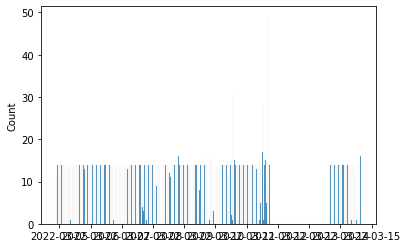

In [2]:
import csv
from datetime import datetime
import seaborn as sns

def parse_arrivals(csv_path, timestamp_col_idx, timestamp_format):
    arrivals = []
    with open(csv_path) as f:
        csv_reader = csv.reader(f)
        # skip header
        next(csv_reader)
        for row in csv_reader:
            arrivals.append(datetime.strptime(row[timestamp_col_idx], timestamp_format))
    arrivals = sorted(arrivals)
    return arrivals

def time_diffs(arrivals):
    return [
        (arrivals[i] - arrivals[i-1]).total_seconds()
        for i in range(1, len(arrivals))
    ]
    
fedsql_arrivals = fedsql_arrivals = parse_arrivals(
    'data/datadog/extract-2022-03-14_16-53-83.csv',
    timestamp_col_idx=0,
    timestamp_format='%Y-%m-%dT%H:%M:%S.%fZ'
)
# the entries every 10 minutes are healthchecks, discard them
fedsql_arrivals = [a for a in fedsql_arrivals if not (a.minute % 10 == 0 and a.second < 10)]
fedsql_diffs = time_diffs(fedsql_arrivals)
                   
# https://www.kaggle.com/datasets/rajeck/health-ecommerce-website-visits
    
#sns.histplot([d for d in diffs if d < 1000])
sns.histplot(fedsql_arrivals, bins=1000)

<AxesSubplot:ylabel='Count'>

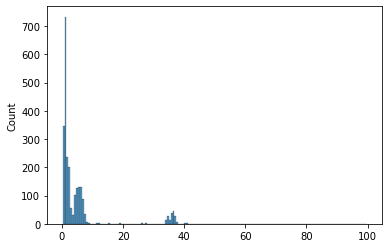

In [3]:
sns.histplot([d for d in fedsql_diffs if d < 100])

Let's take a look at a more comprehensive dataset. We'll use a [health ecommerce website visits dataset from Kaggle](https://www.kaggle.com/datasets/rajeck/health-ecommerce-website-visits)

<AxesSubplot:ylabel='Count'>

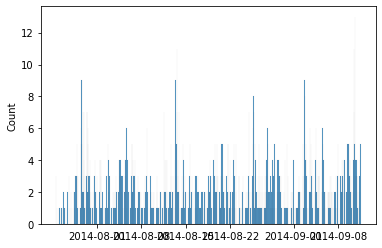

In [5]:
ecommerce_arrivals = parse_arrivals(
    'data/kaggle/health-ecommerce-website.csv',
    timestamp_col_idx=0,
    timestamp_format='%Y-%m-%d %H:%M'
)
ecommerce_diffs = time_diffs(ecommerce_arrivals)
sns.histplot(ecommerce_arrivals, bins=1000)

<AxesSubplot:ylabel='Count'>

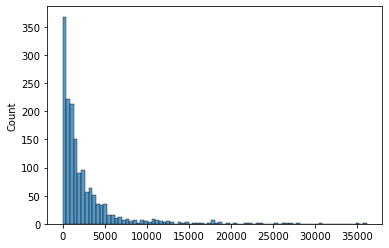

In [6]:
sns.histplot(ecommerce_diffs)

This looks like an exponential distribution!

In [37]:
# the rate, in arrivals/sec
time_span = (ecommerce_arrivals[-1] - ecommerce_arrivals[0]).total_seconds()
_lambda = len(ecommerce_arrivals) / time_span
_lambda

0.00038463582815089707

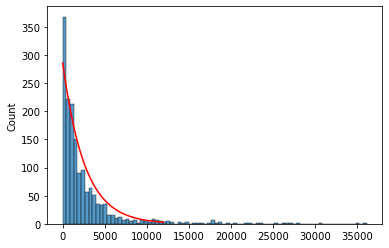

In [40]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
ax = sns.histplot(ecommerce_diffs)

scale = 1/_lambda

x = np.linspace(expon.ppf(0.01, scale=scale), expon.ppf(0.99, scale=scale), 100)
ax.plot(x, expon.pdf(x, scale=scale)*750_000, 'r-') # not sure why *750_000 is needed to match the scale

## Exponential Distribution

Probability density function | Cumulative distribution function
:--------------------------- | :-------------------------------
![](Exponential_pdf.svg)     | ![](Exponential_cdf.svg)
_[by Newystats - Own work, CC BY-SA 4.0](https://commons.wikimedia.org/w/index.php?curid=80359746)_ | _[by Skbkekas - Own work, CC BY 3.0]( https://commons.wikimedia.org/w/index.php?curid=9508326)_

If something happens $\lambda = 1.5$ times a second, there is ~80% chance it will happen within one second.

$E[X] = \frac{1}{\lambda}$

$\lambda = \frac{100}{8 \times 60} = \frac{10}{48}$ messages per minute

$E[X] =$ 4 minutes 48 seconds

In [10]:
from scipy.stats import expon
_lambda = 100 / (8*60)
expon.expect(scale = 1/_lambda)

4.799999999999999

## Markov chains

TODO: standard markov chains

## Continuous time Markov chains

Each edge has a transition rate. When we enter a state, we start exponentially-distributed clock for each outgoing edge and follow the one that ticks first, discarding other clocks.

TODO example of what can be modelled (not hard drives...)
